In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Load dataset
data = pd.read_excel("/Users/rohanshenoy/Downloads/yahoo_data.xlsx")

# Convert 'Date' to datetime and sort
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by="Date", ascending=True)
data.set_index("Date", inplace=True)

# Select the column for time series prediction (e.g., 'Close' price)
target_col = 'Adj Close**'  
data = data[[target_col]]

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_sequences(data, time_steps=50):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Define time step window
time_steps = 50

# Create sequences
X, y = create_sequences(data_scaled, time_steps)

# Split into train and test sets (80% train, 20% test)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (966, 50, 1), Test shape: (242, 50, 1)


In [4]:
# Build LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
31/31 [==============================] - 3s 49ms/step - loss: 0.0584 - val_loss: 0.0035
Epoch 2/20
31/31 [==============================] - 1s 24ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 3/20
31/31 [==============================] - 1s 23ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 4/20
31/31 [==============================] - 1s 25ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 5/20
31/31 [==============================] - 1s 25ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/20
31/31 [==============================] - 1s 26ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 7/20
31/31 [==============================] - 2s 59ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 8/20
31/31 [==============================] - 1s 34ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/20
31/31 [==============================] - 1s 32ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/20
31/31 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 11/

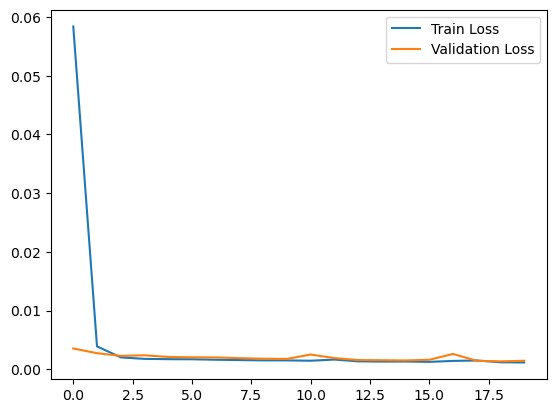

In [5]:
# Train LSTM model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


8/8 [==============================] - 0s 7ms/step
RMSE: 690.53


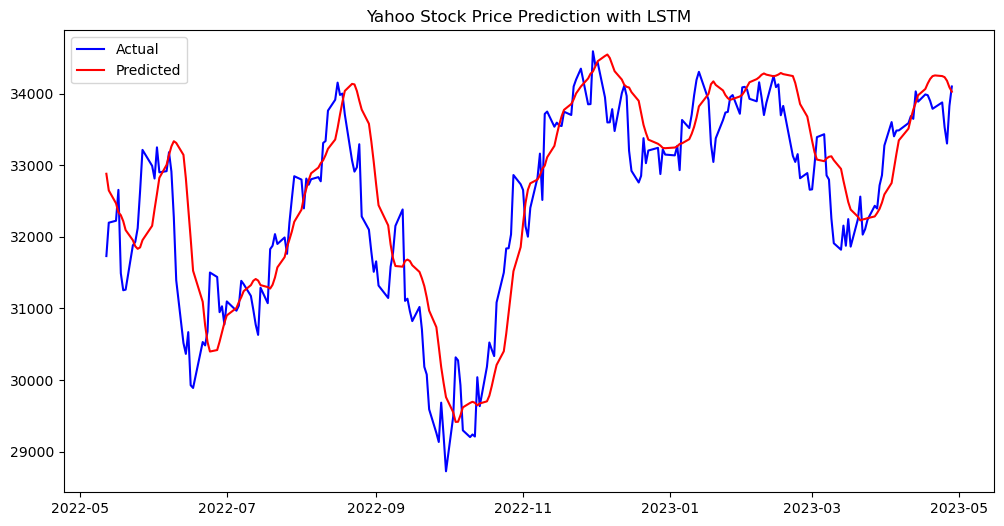

In [6]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"RMSE: {rmse:.2f}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_inv, label="Actual", color='blue')
plt.plot(data.index[-len(y_test):], y_pred_inv, label="Predicted", color='red')
plt.legend()
plt.title("Yahoo Stock Price Prediction with LSTM")
plt.show()
